Random forest เป็นเหมือน Model ที่ตั้ง conditions ขึ้นมาหลายๆอย่างเพื่อที่พยายามจะ Predict y ให้ใกล้เคียงที่สุด

จะมีparameters หลักของ model ก็คือจำนวนครั้งในการสุ่มของ model (1ครั้ง คือ1 ต้น)
และจะมีความลึกของกิ่ง (depth) ที่จะพยายามตั้ง conditions ลงไป (ยิ่งลึกมาก มันจะเป็นเหมือนการพยายามที่จะ overfit โมเดล เพราะยิ่งพยายามจะหาเหตุผลมาทำนาย)

ในการ tune parameter ของ random forest จะใช้การ grid search เข้ามาทำ เพื่อที่จะได้รู้ว่า จำนวนการสุ่มกี่ครั้ง หรือความลึกเท่าไหร่ จะoptimal สุด

เมื่อทำ grid seach(ใช้ for loop ในการทำ grid) ก็จะเลือกค่าที่ดีที่สุด โดยการ sort ดูparameter ที่มีการทำนายถูกทิศทาง มากที่สุด และ sort MSE ที่น้อยที่สุด

การหาว่าอันไหนจะทำนายถูกทิศมากที่สุด ใช้การตั้ง condition ว่าถ้า y*predict แล้วผลลัพท์ มากกว่า 1 คือทิศทางเดียวกัน (เพราะ+*+, -*-จะเท่ากับ +) และนำ column นั้นมา .sum ก็จะได้จำนวนครั้งที่ model parameter นั้นๆ ทายไปในทิศทางเดียวกัน

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
start = '2020-01-01'
end = '2022-01-1'
data = yf.download('CL=F PTTEP.BK OR.BK PTTGC.BK PTT.BK', start= start, end= end)

[*********************100%***********************]  5 of 5 completed


In [3]:
df = data.Close

In [4]:
df = df.fillna(method= 'ffill')
df = df.pct_change()
df = df.dropna()
df = df[['CL=F', 'OR.BK', 'PTTEP.BK', 'PTTGC.BK', 'PTT.BK']]

In [5]:
df[df['CL=F'] == 0]

,CL=F,OR.BK,PTTEP.BK,PTTGC.BK,PTT.BK
Date,,,,,
2021-02-15,0.0,0.162393,0.031390,0.011858,0.024845
2021-04-02,0.0,0.000000,0.013100,-0.007905,-0.006135
2021-05-31,0.0,-0.008264,0.008511,0.003968,0.006369
2021-07-05,0.0,-0.008333,0.008475,0.004167,0.006452
2021-09-06,0.0,0.000000,-0.013636,-0.024390,-0.006536
2021-09-16,0.0,-0.008621,0.004444,0.012500,0.019231
2021-10-25,0.0,0.000000,-0.023904,-0.011364,-0.012500
2021-12-24,0.0,0.019608,-0.004237,0.004292,0.000000


In [6]:
df = df[~(df['CL=F'] == 0)]

# เอาทั้งหมดที่ CL=F เป็น 0 ออก

In [7]:
df.loc[:,['OR.BK','PTTEP.BK','PTTGC.BK','PTT.BK']]

,OR.BK,PTTEP.BK,PTTGC.BK,PTT.BK
Date,,,,
2021-02-12,0.000000,0.000000,0.000000,0.000000
2021-02-16,-0.036765,-0.008696,0.035156,0.000000
2021-02-17,-0.099237,-0.008772,-0.011321,-0.012121
2021-02-18,0.025424,0.008850,0.000000,-0.006135
2021-02-19,0.041322,-0.021930,-0.030534,-0.012346
...,...,...,...,...
2021-12-27,0.038462,0.004255,-0.012821,-0.006579
2021-12-28,0.009259,0.008475,0.008658,0.006623
2021-12-29,0.000000,-0.004202,0.004292,0.006579


In [8]:
df.loc[:,['OR.BK','PTTEP.BK','PTTGC.BK','PTT.BK']].any(axis=1) == 0
# ทุกแถวเป็น 0

Date
2021-02-12     True
2021-02-16    False
2021-02-17    False
2021-02-18    False
2021-02-19    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31     True
Length: 223, dtype: bool

In [9]:
df.loc[df.loc[:,['OR.BK','PTTEP.BK','PTTGC.BK','PTT.BK']].any(1) != 0]

# ดูว่าแถวไหนบ้างที่ ไม่ใช่ 0 ทั้งแถว

,CL=F,OR.BK,PTTEP.BK,PTTGC.BK,PTT.BK
Date,,,,,
2021-02-16,0.009753,-0.036765,-0.008696,0.035156,0.000000
2021-02-17,0.018152,-0.099237,-0.008772,-0.011321,-0.012121
2021-02-18,-0.010141,0.025424,0.008850,0.000000,-0.006135
2021-02-19,-0.021150,0.041322,-0.021930,-0.030534,-0.012346
2021-02-22,0.037981,0.007937,-0.008969,-0.019685,0.000000
...,...,...,...,...,...
2021-12-23,0.014156,0.000000,0.008547,0.008658,0.013333
2021-12-27,0.024122,0.038462,0.004255,-0.012821,-0.006579
2021-12-28,0.005425,0.009259,0.008475,0.008658,0.006623


In [10]:
df = df.loc[~(df.loc[:,['OR.BK','PTTEP.BK','PTTGC.BK','PTT.BK']].all(1) == 0)]

# เอาที่ทั้ง 4 col เป็น 0 ออก

In [11]:
df

,CL=F,OR.BK,PTTEP.BK,PTTGC.BK,PTT.BK
Date,,,,,
2021-02-17,0.018152,-0.099237,-0.008772,-0.011321,-0.012121
2021-02-19,-0.021150,0.041322,-0.021930,-0.030534,-0.012346
2021-02-23,0.002927,-0.023622,0.031674,0.028112,0.012500
2021-02-24,0.025134,-0.008065,-0.004386,-0.019531,-0.024691
2021-03-03,0.025607,0.017094,0.008889,0.027888,0.031447
...,...,...,...,...,...
2021-12-15,0.001979,-0.009804,-0.012500,-0.004292,-0.006623
2021-12-21,0.042357,-0.009804,0.008584,0.004348,-0.006711
2021-12-27,0.024122,0.038462,0.004255,-0.012821,-0.006579


In [12]:
20/92
# จาก ทั้งหมด92แถว ดูแบ่งเทรนเทสกี่เปอ

0.21739130434782608

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [13]:
X = df.iloc[:-20, :-1]
y = df.iloc[:-20, -1:]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20)#, random_state= 10)

In [97]:
rf = RandomForestRegressor(n_estimators= 100, max_depth= 3,  random_state= 4)

In [98]:
rf.fit(X_train, y_train)

<ipython-input-98-168a6fc83696>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=3, random_state=4)

In [99]:
predictions = rf.predict(X_test)

In [100]:
compare = pd.DataFrame(y_test)
compare['predict'] = predictions
compare

,PTT.BK,predict
Date,,
2021-07-15,-0.006667,-0.008855
2021-06-21,-0.006250,-0.014974
2021-08-13,0.014493,-0.004496
2021-09-27,0.012500,0.018154
2021-08-18,-0.006944,0.002686
2021-09-02,0.013333,0.005138
2021-08-19,-0.013986,-0.011520
2021-03-17,-0.006135,0.025066
2021-05-05,-0.012500,-0.016399


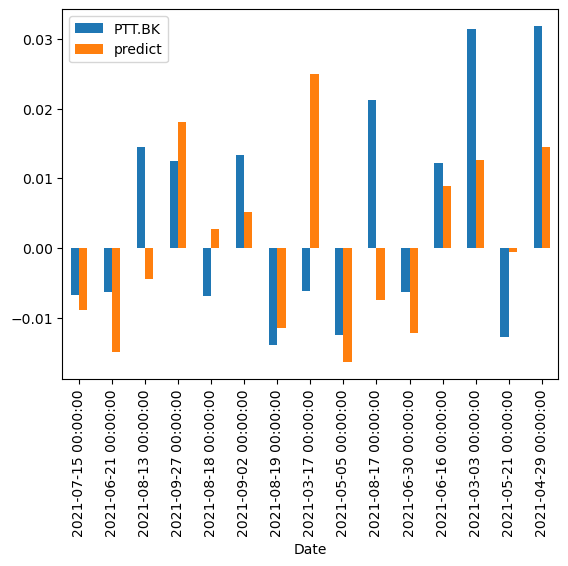

In [101]:
compare.plot(kind= 'bar')
plt.show()

In [102]:
from sklearn.tree import export_graphviz # graph vizualization
import pydot 
#import pydotplus

In [103]:
# tree = rf.estimators_[1]

# export_graphviz(tree, out_file = 'tree.dot', feature_names = X_test.columns, rounded = True, precision = 1)
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# graph.write_png('tree.png')
# Image(filename= 'tree.png')


In [104]:
rf.feature_importances_
# ดูนัยยะแต่ละ faeture (x) ว่ามีความสำคัญต่อ y แค่ไหน (คล้ายๆ r2)

array([0.02880569, 0.15352514, 0.57264816, 0.24502102])

In [105]:
rf_no_random = RandomForestRegressor(n_estimators= 100, max_depth= 3)#,  random_state= 4)
rf_no_random.fit(X_train, y_train)

<ipython-input-105-6f8c4282fe48>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_no_random.fit(X_train, y_train)


RandomForestRegressor(max_depth=3)

In [106]:
predict_no_random = rf_no_random.predict(X_test)

In [107]:
compare['predict_no_random'] = predict_no_random
compare

,PTT.BK,predict,predict_no_random
Date,,,
2021-07-15,-0.006667,-0.008855,-0.009827
2021-06-21,-0.006250,-0.014974,-0.014865
2021-08-13,0.014493,-0.004496,-0.004449
2021-09-27,0.012500,0.018154,0.019993
2021-08-18,-0.006944,0.002686,0.004551
2021-09-02,0.013333,0.005138,0.007550
2021-08-19,-0.013986,-0.011520,-0.012797
2021-03-17,-0.006135,0.025066,0.024274
2021-05-05,-0.012500,-0.016399,-0.017016


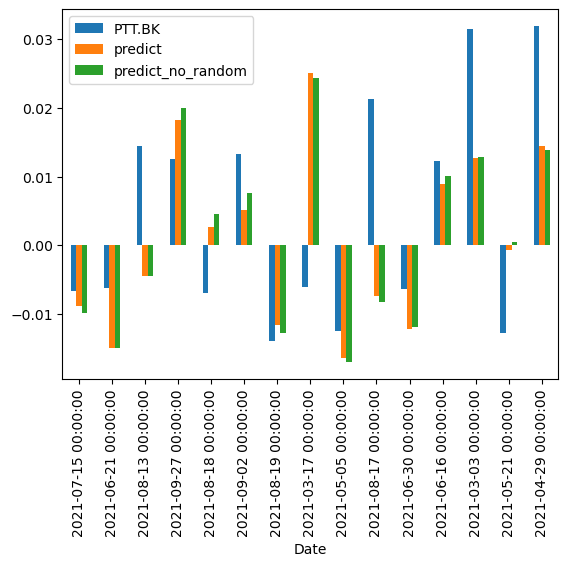

In [108]:
compare.plot(kind= 'bar')
plt.show()

In [109]:
feature_imp = pd.DataFrame(rf.feature_importances_, index= X_test.columns, columns= ['Feature Importance'])
feature_imp

# แสดงให้เห็นว่า CL=F และ OR.BK มีความสำคัญต่ำต่อ y

,Feature Importance
CL=F,0.028806
OR.BK,0.153525
PTTEP.BK,0.572648
PTTGC.BK,0.245021


In [110]:
df.corr() 
# CL=F OR.BK มี corr กับ PTT ต่ำ confirm เช่นเดียวกับ feature importance

,CL=F,OR.BK,PTTEP.BK,PTTGC.BK,PTT.BK
CL=F,1.000000,0.077125,0.201824,0.257080,0.151999
OR.BK,0.077125,1.000000,0.210315,0.074778,0.313473
PTTEP.BK,0.201824,0.210315,1.000000,0.656323,0.697298
PTTGC.BK,0.257080,0.074778,0.656323,1.000000,0.688071
PTT.BK,0.151999,0.313473,0.697298,0.688071,1.000000


In [111]:
new_X_train = X_train.iloc[:, 2:]
new_X_test = X_test.iloc[:, 2:]
new_X_test

,PTTEP.BK,PTTGC.BK
Date,,
2021-07-15,-0.008969,0.004405
2021-06-21,-0.008475,-0.017021
2021-08-13,-0.004831,0.012658
2021-09-27,0.035398,0.020661
2021-08-18,0.004831,-0.008230
2021-09-02,0.004566,0.011952
2021-08-19,-0.014423,-0.033195
2021-03-17,0.017241,-0.022140
2021-05-05,-0.012605,-0.014760


In [112]:
rf_new = RandomForestRegressor(n_estimators=100, max_depth =3,random_state =9)
rf_new.fit(new_X_train, y_train)
predict_new = rf_new.predict(new_X_test)
compare['predict_new'] = predict_new
compare.plot(kind='bar')

<ipython-input-112-ad918f722e26>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_new.fit(new_X_train, y_train)


<AxesSubplot:xlabel='Date'>

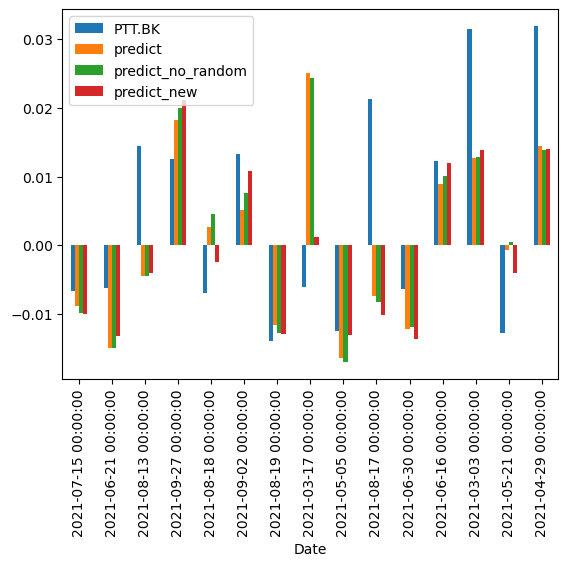

In [113]:
plt.show()

# Parameters Tuning

เพื่อที่จะต้องการ trial and error ได้สดวกๆ เลยใช้วิธีการสร้าง function ขึ้นมาเพื่อทำมัน

In [15]:
def randomforest(X_train, y_train, X_test, y_test, n= 100, how= 'mse', depth= 3):
    rf = RandomForestRegressor(
        n_estimators= n, 
        criterion= how, 
        max_depth= depth
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

In [74]:
test = randomforest(X_train, y_train, X_test, y_test, how= 'mae')
test

[ 0.02013812 -0.00151374 -0.01107229  0.00049992  0.01334568 -0.00857705
 -0.00640452 -0.01260745 -0.00578692  0.01657035 -0.00033523  0.00416816
  0.00018973  0.01371638 -0.00689109]


<ipython-input-73-a575f001e767>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


array([ 0.02013812, -0.00151374, -0.01107229,  0.00049992,  0.01334568,
       -0.00857705, -0.00640452, -0.01260745, -0.00578692,  0.01657035,
       -0.00033523,  0.00416816,  0.00018973,  0.01371638, -0.00689109])

In [16]:
def grif_rf(X_train, y_train, X_test, y_test, n_choice, how_choice, depth_choice):
    results_list = []

    for i in n_choice:
        for j in how_choice:
            for k in depth_choice:
                result, y_pred = randomforest(
                    X_train, y_train, X_test, y_test, n= i, how= j, depth= k)

                compare = pd.DataFrame()
                compare['y_test'] = y_test
                compare['predict'] = y_pred
                direction_ok = (compare.product(1) > 0).sum()
                
                ##### คิด error 
                # ลองแบบคิดวิธีเดียว คือ 
                #mse = mean_squared_error(y_test, y_predict)
                
                # ลองใช้ if how_choice == 'mae':
                            # return error = mean_squared_error(y_test, y_predict) 
                        # else:
                            # return 
                results_list.append([i, j, k, result, direction_ok])
            

    return results_list

In [17]:
n_grid = [100, 200, 300]
how_grid = ['mse', 'mae']
depth_grid = [3, 4, 5]
test = grif_rf(X_train, y_train, X_test, y_test, n_grid, how_grid, depth_grid)
test

<ipython-input-15-c1f7a6446ddf>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
<ipython-input-15-c1f7a6446ddf>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
<ipython-input-15-c1f7a6446ddf>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
<ipython-input-15-c1f7a6446ddf>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
<ipython-input-15-c1f7a6446ddf>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

[[100, 'mse', 3, 0.0001137436955989561, 14],
 [100, 'mse', 4, 0.00011489316413571768, 14],
 [100, 'mse', 5, 0.00011167547102469916, 14],
 [100, 'mae', 3, 0.00013030368084868805, 14],
 [100, 'mae', 4, 0.00011529854450271483, 14],
 [100, 'mae', 5, 0.00012565552339874702, 14],
 [200, 'mse', 3, 0.0001214413142498908, 14],
 [200, 'mse', 4, 0.00011352070853252131, 14],
 [200, 'mse', 5, 0.00011191765691348893, 14],
 [200, 'mae', 3, 0.00012637839862131585, 14],
 [200, 'mae', 4, 0.00011013128968470105, 14],
 [200, 'mae', 5, 0.00011369469952256363, 14],
 [300, 'mse', 3, 0.00011814166446588514, 14],
 [300, 'mse', 4, 0.00011349547155152857, 14],
 [300, 'mse', 5, 0.00011089544955005022, 14],
 [300, 'mae', 3, 0.00011728563777955619, 14],
 [300, 'mae', 4, 0.00011768242647268012, 14],
 [300, 'mae', 5, 0.00011098392559283399, 14]]

In [18]:
df_grid = pd.DataFrame(test)

In [19]:
df_grid.columns = ['n_estimators', 'method', 'depth', 'error', 'correct_direction']

ดูแค่ Error ไม่พอ เพราะมันแค่มิติเดียว ต้องลองเอามา compare กันมิติอื่นๆ  
จะดูเป็นกราฟก็จะเยอะไป  
เลยทำเป็นวิธี count ทางที่ predict กับ actual(y) ไปในทิศทางเดียวกัน + +, - -  
(ปกติจะใช้ downside capture, upside capture แต่มันทำยังไง?) 

In [21]:
df_grid.sort_values(['correct_direction', 'error'], ascending= [False, True]) # false มากไปน้อย, True น้อยไปมาก

,n_estimators,method,depth,error,correct_direction
10,200,mae,4,0.000110,14
14,300,mse,5,0.000111,14
17,300,mae,5,0.000111,14
2,100,mse,5,0.000112,14
8,200,mse,5,0.000112,14
13,300,mse,4,0.000113,14
7,200,mse,4,0.000114,14
11,200,mae,5,0.000114,14
0,100,mse,3,0.000114,14
1,100,mse,4,0.000115,14


parameter ที่ดีที่สุดคือ n=200, method= mae, depth= 4